# <center> <h1> Testing </h1> </center>

<img src="../images/tests.png" width="200">

_TODO :_
- mettre la référence de la page wikipédia
- écrire une introduction

In [1]:
get_ipython().magic(u'matplotlib inline')
%run -i ../utils/credentials.py
%run -i ../utils/imports.py
%run -i ../utils/plots.py
%run -i ../utils/stats.py

# Le principe

On cherche à valider ou invalider une hypothèse $H_0$ face à une hypothèse alternative. Pour cela on procède en plusieurs étapes : 
* On pose l'hypothèse nulle $H_0$ et l'hypothèse alternative $H_1$
* Ensuite on calcule une statistique de test notée $S$, qui est une variable aléatoire dont on connaît la loi de probabilité si $H_0$ est vraie
* On calcule la réalisation de cette variable aléatoire que l'on note $S_{obs}$
* On calcule la probabilité d'obtenir cette valeur si $H_0$ est vérifiée pour décider si cette hypothèse est crédible ou non

### Exemple d'un test unilatéral

On veut tester si la valeur de l'espérance d'une variable aléatoire est inférieure ou égale à un nombre $\mu$. On ne va rejeter l'hypothèse nulle que lorsque la moyenne empirique $\bar{x}$ est significativement plus grand que $\mu$. 

Nos hypothèses sont :

* $H_0 : E[X]=\mu$
* $H_1 : E[X]>\mu$ (inégalité car le test est unilatéral)

Sous $H_0$, le théorème central limite nous donne que si n est suffisamment grand on a :
$$\frac{\bar{X}-\mu}{\sqrt{\frac{\sigma^2}{n}}} \sim \mathcal{N}\Big(0,1\Big)$$ 

Toutefois, nous ne connaissons pas $\sigma$. Nous devons estimer la variance de la moyenne par la variance empirique :
$$ \hat{\sigma}^2=\sum_i{\frac{(X_i-\bar{X})^2}{n}}$$

Sous$H_0$, les proriétés sur les lois de probabilité nous donnent :
$$S = \frac{\bar{X}-\mu}{\sqrt{\frac{\sigma^2}{n}}} \sim \mathcal{t}(n-1)$$ 

On va utiliser cette propriété est rejeter $H_0$ si $S$ dépasse un certain seuil.

Ce test est __unilatéral__ car l'hypothèse alternative est une inégalité, ce qui signifie que l'on ne rejette pas l'hypothèse $H_0$ si la valeur de la moyenne empirique est plus petite que $\mu$.

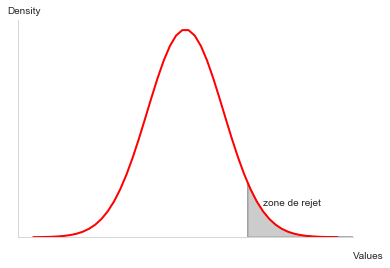

In [2]:
plot_proba(S = 1.64,
           label_pos = 2.8,
           limite_name = "$|S_{obs}|$",
           stat_name = "S",
           sym = False,
           message_1 = "zone de rejet",
           message_2= "zone de rejet")

### Exemple d'un test bilatéral

On veut tester si la valeur d'une moyenne est différente de $\mu$. On va rejeter l'hypothèse nulle dès que la moyenne empirique $\bar{x}$ est significativement différente de $\mu$. On a alors :

* $H_0 : E[X]=\mu$
* $H_1 : E[X] \neq \mu$

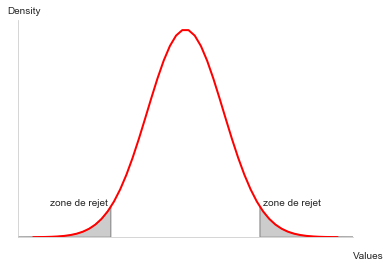

In [3]:
plot_proba(S = 1.96,
           label_pos = 2.8,
           limite_name = "$|S_{obs}|$",
           stat_name = "S",
           sym = True,
           message_1 = "zone de rejet",
           message_2= "zone de rejet")

## Mise en pratique d'un test d'indépendance du $\chi^2$

Lorsque l'on a des variables qualitatives on peut vouloir tester leur indépendance deux à deux pour savoir si des caractéristiques son liées entre elles.

Si on a deux variables X et Y, dont les modalités sont respectivement $(X_1,X_2,X_3)$ et $(Y_1,Y_2)$, on veut donc savoir si le groupe des individus ayant la caractéristique $Y_1$ et celui des individus ayant la caractéristique $Y_2$ se répartissent de la même manière selon la variable $X$.

__NB__ : le problème est symétrique, on peut donc chercher à savoir si les sous-groupes selon la variables X se répartissent de la même manière selon la variable Y.

On note $I$ l'ensemble des modalités de $X$ et $J$ l'ensemble des modalités de $Y$.

#### Use case

Ici on souhaite savoir si la répartition du nombre de kill (variable quantitiative considérée ici comme une variable quatégorielle) est statistiquement la même pour les parties de type 'solo-fpp' ou les parties de type 'squade'.

In [4]:
data_path = "../data/PUBG_train_sample.csv"
data_PUBG = pd.read_csv(data_path)
data_PUBG = data_PUBG.loc[data_PUBG["matchType"].isin(["solo-fpp","squad"]),:].sample(frac=0.05, 
                                                                                      replace=False, 
                                                                                      random_state=1234)

In [5]:
cont = pd.crosstab(data_PUBG.matchType, data_PUBG.killStreaks)
cont

killStreaks,0,1,2,3,4
matchType,,,,,
solo-fpp,340,250,15,0,0
squad,403,229,50,13,1


### 1/ Table de contingence en cas d'indépendance parfaite

Pour chaque couple possible $(i,j)$ on note $O_{ij}$ le nombre d'individus pour lesquel la caractéristique $X$ vaut $X_i$ et la caractéristique $Y$ vaut $Y_j$.

Pour chaque couple $(i,j)$, on commence par calculer la répartition théorique en cas d'indépendance parfaite (notée $E_{ij}$). Pour chaque couple de modalité $(i,j)$ (par exemple (killStreaks = 3, matchType= "squad"), cette répartition est donnée par :

$$E_{ij} = \frac{O_{i+} \times O_{+j}}{N}$$

Avec :
- $O_{i+} = \sum_{j}O_{ij}$ : le nombre d'individus pour lesquel la caractéristique $X$ vaut $X_i$
- $O_{+j} = \sum_{i}O_{ij}$ : le nombre d'individus pour lesquel la caractéristique $Y$ vaut $Y_j$
- $N$ : le nomre d'individu total

In [6]:
N = cont.sum(axis=1).sum(axis=0)
E_table = pd.DataFrame(columns=cont.columns, index=cont.index)

for i in range(len(E_table)):
    for j in range(len(E_table.columns)):
        E_table.iloc[i,j] = (cont.iloc[:,j].sum()*cont.iloc[i,:].sum())/N

In [7]:
E_table

killStreaks,0,1,2,3,4
matchType,,,,,
solo-fpp,345.515,222.748,30.2267,6.04535,0.465027
squad,397.485,256.252,34.7733,6.95465,0.534973


### 2/ Distance entre la table théorique et la table réelle

Ensuite on compare cette répartition théorique idéale en cas d'indépendance avec la répartition réelle. On note $T$ la valeur de la distance entre les deux situations :
$$T = \sum_{ij}\frac{(O_{ij}-E_{ij})^2}{E_{ij}} $$

T est une variable aléatoire qui peu prendre plusieurs valeurs. On peu calculer la valeur prise par $T$ dans notre expérience , que l'on appellera $T_{exp}$ est qui sera un nombre (i.e une réalisation de la variable aléatoire $T$).

In [8]:
T_ij = ((E_table - cont)**2)/E_table
T_exp = T_ij.sum(axis=0).sum()

In [9]:
T_exp

32.904560053824554

### 3/ Utilisier la théorie statistique pour déterminer la loi de T sous l'hypothèse d'indépendance

On fait deux hypothèses :
- $H_0$ : X et Y sont des variables indépendantes
- $H_1$ : X et Y sont liées

Or on sait que sous l'hypothèse $H_0$ on a :
$$T \sim \chi^2 (M)$$

Avec : 
$M = (card(I)-1)\times(card(J)-1)$

On note $Z_{5\%}$ la valeur telle qu'une variable aléatoire de loi i $\chi^2 (M)$ a 5% de chance de prendre un valeur plus grande que ce seuil.

Sous l'hypothèse nulle $H_0$, la probabilité que T prenne une valeur plus grande que $Z_{5\%}$ est donc de 5% (l'air grise sous la courbe vaut 5%).

In [10]:
loi_T = scs.chi2(8)
confidence = 0.95

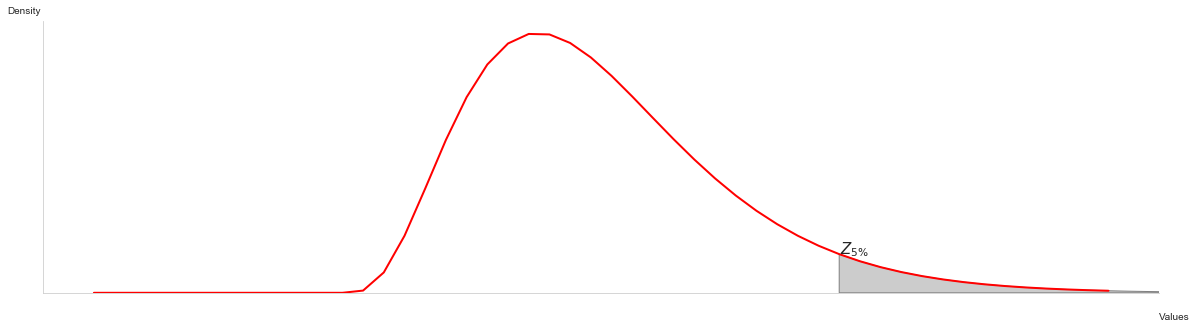

In [11]:
plt.rcParams["figure.figsize"] = (20,5)
plot_proba(S = loi_T.ppf(confidence),
           label_pos = 16,
           sym = False,
           limite_name = "test",
           message_1 = "$Z_{5\%}$",
           stat_name = "",
           fontsize_message_1=15,
           loi = loi_T)
plt.show()

### 4/ Décider si on retient l'hypothèse nulle ou non

Or la valeur réelle prise par T est dans notre cas bien plus élevée que ce seuil. Sou l'hypothèse $H_0$, Il y a donc très peu de chance que nous soyons tombé sur cette valeur. Nous rejetons donc l'hypothèse nulle.

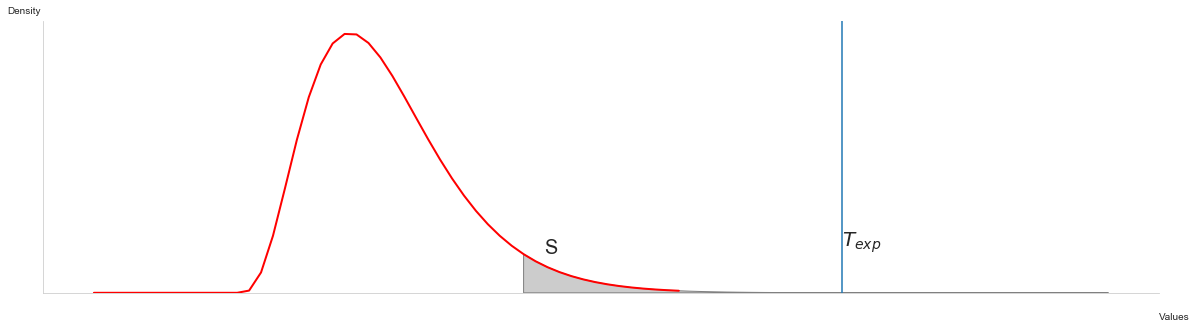

In [12]:
plt.rcParams["figure.figsize"] = (20,5)
plot_proba(S = loi_T.ppf(confidence),
           label_pos = 17,
           sym = False,
           limite_name = "",
           message_1 = "S",
           fontsize_message_1 = 20,
           stat_name = "",
           loi = loi_T)

plt.plot((T_exp,T_exp),(0,1))
plt.text(T_exp,0.02,"$T_{exp}$", fontsize = 20)

plt.show()

## Interpréter la p-value

On peut également calculer la probabilité que la variable $T$ prenne la même valeur ou une valeur plus élevée que $T_{exp}$ sous l'hypothèse nulle. Cela évite d'avoir à effectuer une comparaison par rapport à un seuil.

La valeur calculée est appelée la $p-value$

In [13]:
import scipy.stats as st
st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)

In [14]:
st_chi2

32.904560053824554

In [15]:
print("la probabilité d'obtenir une statistique plus élevée sous $H_0$ est de {}%".format(round(st_p*100)))

la probabilité d'obtenir une statistique plus élevée sous $H_0$ est de 0.0%


Ici la $p-value$ est extrêmement faible.

In [16]:
round(st_p*100,200)

0.00012494467230059582

On a de bonnes raison de rejeter l'hypothèse nulle d'indépendance des variables.

## Une alternative : le test exact de Fisher

Le test exact de Fisher peut être utilisé lorsque les échantillons sont de taille faible.
cf. : https://fr.wikipedia.org/wiki/Test_exact_de_Fisher

In [17]:
p_val = st.fisher_exact(cont.iloc[0:2,0:2], alternative='two-sided')[1]
print("la probabilité d'obtenir une statistique plus élevée sous $H_0$ est de {}%".format(round(p_val*100)))

la probabilité d'obtenir une statistique plus élevée sous $H_0$ est de 3.0%


Conclusion on rejette l'hypothèse $H_0$.

# Un problème de taille !

Les théorèmes utilisée pour réaliser des tests (théorème central limite) étant asymptotique, il faut resterprudent lorsque les effectifs sont faibles. Pour s'en convaincre il suffit de réaliser quelques tests sur des tailles d'échantillon différents.

In [19]:
data_PUBG = pd.read_csv(data_path)
data_PUBG = data_PUBG.loc[data_PUBG["matchType"].isin(["solo-fpp","squad"]),:]
fracs = [0.05, 0.01, 0.005]

In [27]:
from numpy.random import choice
sample_size = 10
data_Y1 = choice(["a","b","c"],
                sample_size,
                p = [0.1,0.5,0.4])
data_Y2 = choice(["a","b","c"],
                sample_size,
                p = [0.1,0.5,0.4])

df = pd.DataFrame({"Y1":data_Y1,
                   "Y2":data_Y2})

cont = 

In [30]:
pd.DataFrame({"Y1":data_Y1,
              "Y2":data_Y2})

,Y1,Y2
0,c,b
1,b,b
2,c,c
3,c,b
4,c,c
5,c,a
6,c,c
7,b,c
8,b,c
9,a,c


In [20]:
len(data_PUBG)

26019

In [21]:
results = {}
for frac in fracs:
    pvals=[]
    T_obs = []
    for ii in range(1000) :
        data = data_PUBG.sample(frac=frac, replace=False)
        cont = pd.crosstab(data.matchType, data.killStreaks)
        st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)
        T_obs.append(st_chi2)
        pvals.append(round(st_p,5))
        #print("{} , {}".format(st_p*100,st_chi2))
    results["p_values_{}".format(frac)] = pvals
    results["T_obs_{}".format(frac)] = T_obs

In [22]:
results_pd = pd.DataFrame(results).iloc[:,[0,2,4]].transpose()

In [23]:
labels = [round(x*len(data_PUBG)) for x in fracs]

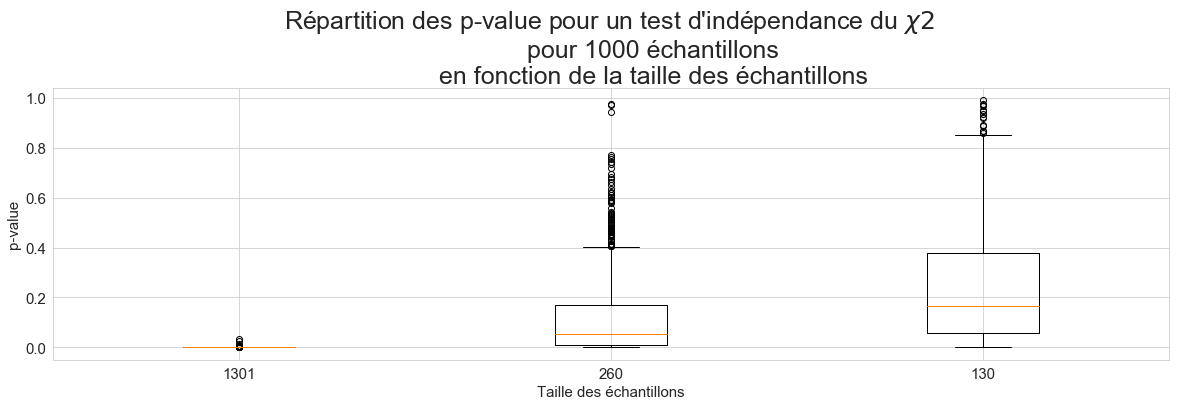

In [24]:
plt.boxplot(results_pd)
plt.xticks([1,2,3], labels, fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel("p-value", fontsize = 15)
plt.xlabel("Taille des échantillons", fontsize = 15)
plt.title("Répartition des p-value pour un test d'indépendance du $\chi2$ \n\
            pour 1000 échantillons\n\
            en fonction de la taille des échantillons", fontsize = 25)
plt.show()

<center> <h1>Take away</h1> </center>

<img src="../images/coffee.png" width="200">


__Expresso__ : 

* point 1
* point 2

__Sugar Story__ :

* point 1
* point 2

# Get more on my github <img src="../images/github.png" width="100">
https://github.com/JJublanc/statistics_tools